In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import os

import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch

import gait
import utils

In [2]:
import mog_data

p = [3, 6, 5, 6, 6, 5, 1]
p = np.array(p) / np.sum(p)

mus = [[-3.5, -1], [0.5, 0.5], [-2, -2], [2.5, 3],
      [-1, 2], [1, -2], [0, 0]]

covs = [[[0.2,0.2], [0.2, 1.5]], [[1, 0], [0, 1]],
        [[1, -0.5], [-0.5, 1]], [[1, 0], [0, 1]],
        [[1, 1.2], [1.2, 3]], [[0.8, 0.5], [0.5, 1]],
        [[3, 0], [0, 3]]]

x, y = np.mgrid[-5:4:.05, -4:5:.05]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y

rvs = mog_data.create_rvs(p, mus, covs)

In [3]:
kernel = lambda x, y: gait.generic_kernel(x, y, lambda u, v: gait.poly_kernel(2*u, 2*v, 1.5))

m, n, d = 200, 200, 2

tp = torch.Tensor(np.ones((1, m))/m)
Y = torch.Tensor(mog_data.sample_mix(rvs, p, m))

# These are the parameters
logit_q = torch.nn.Parameter(0*torch.Tensor(np.random.rand(1, n))).requires_grad_(False)
q = torch.softmax(logit_q, dim=1)
X = torch.nn.Parameter(Y[torch.randint(m, (n, 1)).squeeze(), ...])
optim_list = [torch.optim.Adam([X], lr=0.05, amsgrad=True)] #,torch.optim.Adam([logit_q], lr=0.05) ] 

In [4]:
for _ in range(500):
    
    [o.zero_grad() for o in optim_list]
    
    # Sample fresh minibatch of real data
    Y = torch.Tensor(mog_data.sample_mix(rvs, p, m))
    
    loss = gait.breg_mixture_divergence(tp, Y, q, X, kernel)
    
    if _ % 100 == 0:
        print("%d - %.4f" % (_, loss.item()))
    loss.backward()
    [o.step() for o in optim_list]

0 - 0.1859
100 - 0.1077
200 - 0.1054
300 - 0.1022
400 - 0.1039


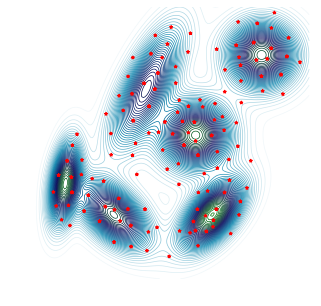

In [7]:
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Lucida Grande']
rcParams['font.size'] = 12

plt.figure(figsize=(5,5))
cset = plt.contour(x, y, mog_data.eval_mix_pdf(pos, rvs, p), 50, linewidths=0.7, cmap=cm.ocean_r, antialiased=True)
plt.grid(False)

Y = mog_data.sample_mix(rvs, p, 400)
#plt.scatter(Y[0:200, 0], Y[0:200, 1], marker='*', c='r', label='Real Samples', alpha=0.4, zorder=5);
plt.scatter(X.data.numpy()[:, 0], X.data.numpy()[:, 1], s=list(2000*q.data.squeeze().numpy()), label='Atomic Approximation', marker='*', c='r', alpha=1, zorder=10)
plt.xlim([-4.5, 4])
plt.ylim([-4, 4.5])
plt.axis('off')
#plt.savefig('supersamples_data_model', dpi=100)
plt.show()